In [1]:
import MDAnalysis as mda 
import matplotlib.pyplot as plt
import numpy as np

import clustering.cluster as psw_cluster
import ICSI.icsi as icsi
import IPI.ipi as ipi

/Users/rmz/opt/anaconda3/envs/pol/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topology_ = '../../../for_hrach/tx114/production.tpr'

trajectory_ = '../../../for_hrach/tx114/production.trr'

u=mda.Universe(topology_,trajectory_)

micelle=u.select_atoms('not name HW? OW')


In [3]:
largest_cluster_resids=psw_cluster.find_largest_cluster(u,
                                   frame=10,
                                   selection='name C*',
                                   cutoff_distance=6,
                                   define_clustering_atoms=False)()
print(largest_cluster_resids)

[139, 141, 27, 30, 37, 49, 50, 52, 69, 70, 73, 78, 81, 84, 89, 99, 104, 114, 116, 120, 124, 125]


In [4]:
c=psw_cluster.find_all_clusters(u,
                                frame=10,
                                selection='name C*',
                                cutoff_distance=6,
                                define_clustering_atoms=False)()
print(c)

[[0, 19, 141], [1, 40, 105, 16, 116, 120], [2, 66, 5, 135, 41, 43, 111, 84, 85, 118, 95, 62, 127], [24, 57, 114, 3], [10, 4, 76], [32, 33, 132, 133, 6, 42, 20, 117, 86, 121, 28], [112, 7], [8], [129, 9, 12, 143, 144, 18, 23, 39, 45, 50, 54, 55, 61, 63, 65, 70, 81, 91, 92, 104, 110], [122, 11, 71, 47], [100, 13, 17, 89, 60], [14], [15], [21], [82, 75, 22], [34, 131, 44, 52, 25], [138, 140, 26, 29, 36, 48, 49, 51, 68, 69, 72, 77, 80, 83, 88, 98, 103, 113, 115, 119, 123, 124], [27], [96, 130, 37, 90, 30], [31], [35], [38], [46], [109, 53], [56], [58], [59], [64], [67], [73], [74], [78], [79], [87], [148, 93], [94], [136, 97], [99], [101, 134], [102], [106], [145, 107], [108], [125], [126], [128], [137], [139], [142], [146], [147], [149]]


In [5]:
micelle_shell= 'resname TX4 and not name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A '
micelle_core= 'resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A '

cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions,solvent_atoms_positions=psw_cluster.make_cluster_whole(u,
                                frame = 10,
                                cluster_resids  = largest_cluster_resids,
                                core_selection  = micelle_core,
                                shell_selection = micelle_shell)()

(array([ 60., 124., 205., 199., 222., 320., 248., 221.,  81.,  58.]),
 array([31.054134, 37.12134 , 43.188553, 49.25576 , 55.322968, 61.390175,
        67.45738 , 73.5246  , 79.591805, 85.65901 , 91.72622 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

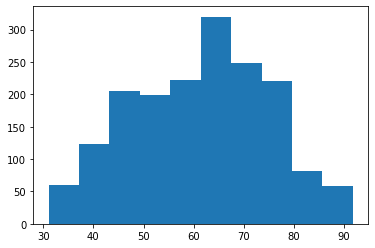

In [40]:
plt.hist(shell_sel_atoms_positions[:,1])
# plt.savefig('ignore.pdf')
# plt.show()
# plt.hist(core_sel_atoms_positions[:,1])
# plt.show()
# plt.hist(shell_sel_atoms_positions[:,1])
# plt.show()

In [8]:
intrinsic_r, spherical_r, icsi_vals =psw_icsi.icsi(u, 
                                                        
                                    cluster_resids=largest_cluster_resids,
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions=shell_sel_atoms_positions,
                                    frame=100,
                                    no_bins=31,
                                    no_random_points=10000,
                                    normalisation_run=False)()

In [2]:
slab=mda.Universe('../../../interface_f8bt/f8bt_psma200/nvt-eq/int_npt.tpr',
               '../../../interface_f8bt/f8bt_psma200/nvt-eq/int_npt_skip2.xtc')

In [10]:
intrinsic_z = ipi.ipi(slab,
                                 frame=-7,
                                 core_sel='resname UNK and prop mass >2',
                                 density_sel='resname SMA and type C*',
                                 interface='Lower', #Lower or Upper... 
                                 no_bins=51,
                                 recombine=True, ###set true if you're using a slab/bilayer (not seperated monolayers!)
                                 cluster=True,#if you want to check if anything has escaped slab/bilayer so it's not included
                                 interpolate_interface=False)() ###can use this if the layer is patchy

In [ ]:
stats

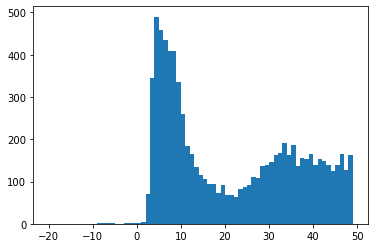

In [9]:
plt.hist([-i for i in intrinsic_z],bins=np.arange(-20,50,1))
plt.show()

In [ ]:
###could make this work for monolayer (and patchy) by setting recomb off (making sel before...)
### and by setting clustering off for patchy...


#intrinsic density - does one frame at a time for flexibility and RAM reqs
z_o = np.zeros([len(np.arange(-30,50,1))])

for ts in u.trajectory[-100::20]:
    
    z,z_fixed = planar_intrinsic_density(u,
                                 timestep=ts.frame,
                                 core_sel='resname UNK and prop mass >2',
                                 density_sel='resname SMA and type C*',
                                 interface='Lower', #Lower or Upper... 
                                 no_bins=51,
                                 recombine=True, ###set true if you're using a slab/bilayer
                                 cluster=True,#if you want to check if anything has escaped slab/bilayer so it's not included
                                 interpolate_interface=False)#if it's patchy...
#                                  interpolate_interface=True) 
    ###might only want to use cluster for bilayers...
    y,a,b=plt.hist(np.array(z),bins=np.arange(-30.5,50,1))
    plt.close()
    z_o+=y
    print(ts)
    
    
#intrinsic tracking (can do by carefully designing main fn and still low RAM req...)

intrinsic_z_tracking=[]

for ts in u.trajectory[-100::20]:
    
    z,z_fixed = planar_intrinsic_density(u,
                                 timestep=ts.frame,
                                 core_sel='resname UNK and prop mass >2',
                                 density_sel='resname SMA and type C*',
                                 interface='Lower', 
                                 no_bins=51,
                                 recombine=True, ###set true if you're using a slab/bilayer
                                 cluster=True) #if you want to check if anything has escaped slab/bilayer so it's not included
    ###might only want to use cluster for bilayers...

    intrinsic_z_tracking.append(z)
    print(ts)